# Software development patterns through git data mining

In [1]:
import sys, os, getpass, warnings
warnings.filterwarnings('ignore')
from patterns.visualizer import Visualizer

Create a `Visualizer` object for a project, e.g., for Spack, `vis = Visualizer('spack')`. This brings in data from database and annotate it with *locc*, *locc+*, *locc-*, *change-size-cos* = *1-similarity* (**expensive call**). The data is cached locally after it's fetched from the database and subsequently loaded from disk, unless you specify the `cache=False` parameter, e.g., `vis.get_data(cache=False)`. Available projects include `'lammps', 'spack', 'petsc', 'Nek5000', 'nwchem', 'E3SM', 'qmcpack', 'qdpxx'` (the full list can be obtained with by calling the `Visualizer()` constructor without arguments.

The `get_data` method automatically removes changes associated with non-code files. The determination of what is code is made by including common suffixes, as well as checking manually a sampling of ECP projects for the suffixes used for things that can be labeled as code (vs. input simulation data, documentation, or generated files), for a list of suffixes, refer to the `Patterns.code_suffixes` list in [patterns.py](https://github.com/HPCL/ideas-uo/blob/master/src/patterns/patterns.py). This makes the analysis of decades of project data feasible. You can disable this if desired, by passing the `code_only=False` parameter to `get_data`. You can also explicitly remove non-code rows with `vis.remove_noncode()`.

In [2]:
vis = Visualizer(project_name='qmcpack')
vis.get_data()

Database password: ·······


INFO: Loading data from database. This can take a while...
INFO: Loaded qmcpack data from the database.
INFO: Done computing averages.


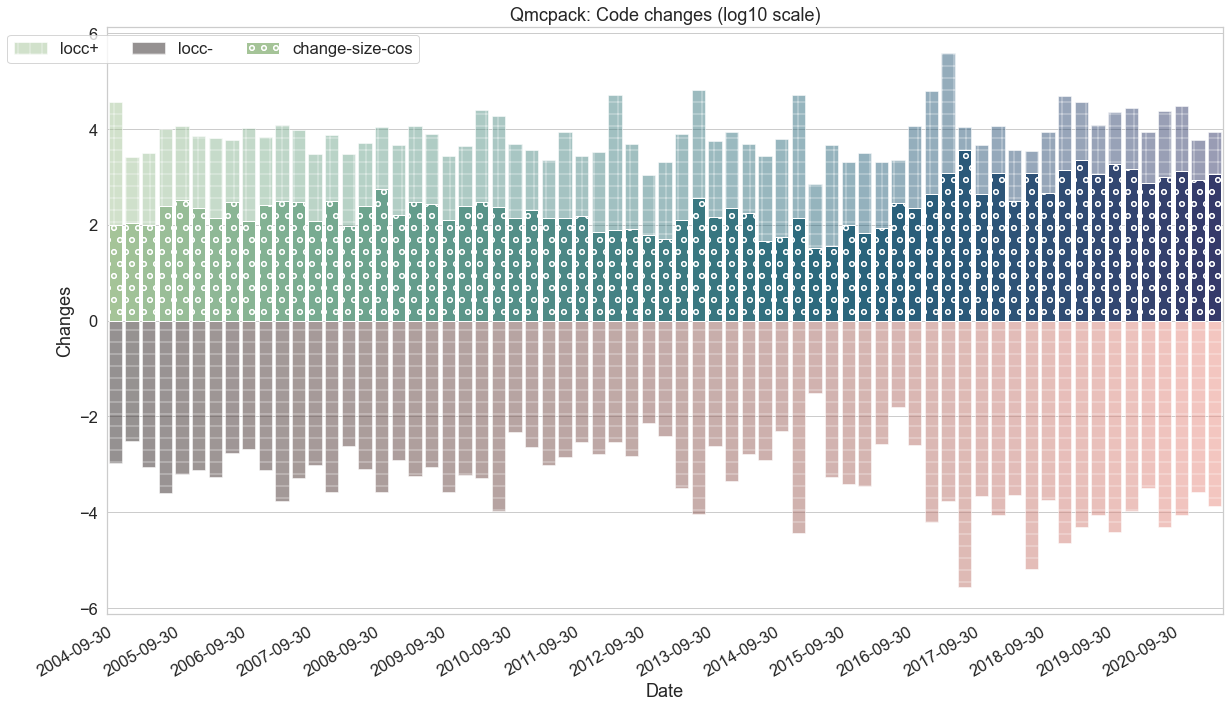

In [3]:
df = vis.plot_overall_project_locc(time_range=None, log=True)

to focus on a given year and/or month, set *year* and *month* fields

In [4]:
vis.set_year(2020)
vis.set_month(7)

to plot for a given year, provide *time_range='year'*

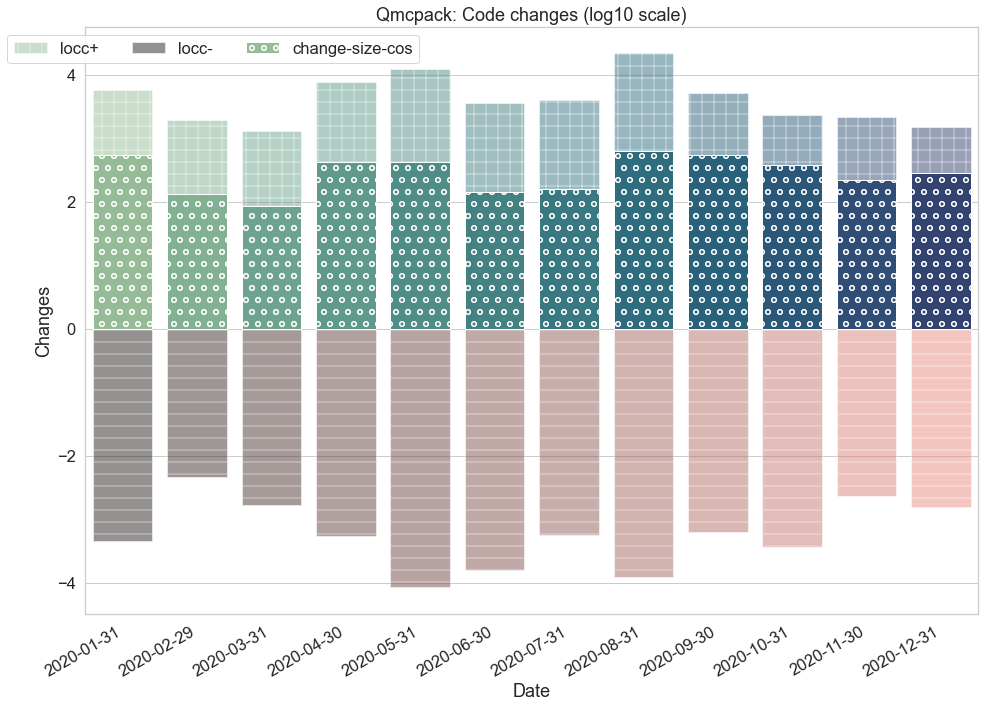

In [5]:
df = vis.plot_overall_project_locc(time_range='year',log=True)

similarly to plot for a given month, set *time_range='month'*

,year,month,day,doy,locc-basic,locc,locc-,locc+,change-size-cos,date
datetime,,,,,,,,,,
2020-07-01,8080,28,4,732,39,33,-1.146128,1.113943,0.602060,2020-07-01
2020-07-02,4040,14,4,368,14,14,inf,1.146128,-inf,2020-07-02
2020-07-03,0,0,0,0,0,0,inf,-inf,-inf,2020-07-03
2020-07-04,0,0,0,0,0,0,inf,-inf,-inf,2020-07-04
2020-07-05,30300,105,75,2805,2,1,inf,-inf,0.000000,2020-07-05
2020-07-06,46460,161,138,4324,439,362,-2.164353,2.143015,1.079181,2020-07-06
2020-07-07,6060,21,21,567,27,24,-0.000000,1.301030,0.477121,2020-07-07
2020-07-08,0,0,0,0,0,0,inf,-inf,-inf,2020-07-08
2020-07-09,22220,77,99,2101,33,32,-1.204120,1.176091,0.698970,2020-07-09


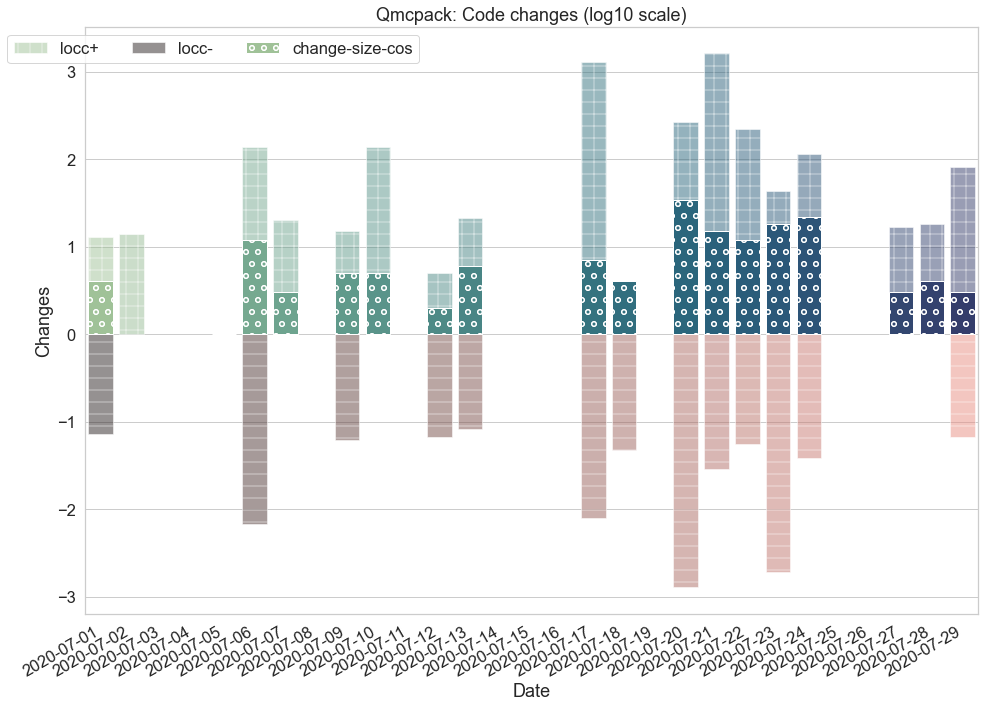

In [6]:
vis.plot_overall_project_locc(time_range='month',log=True)

### Averages: Total changed lines over time

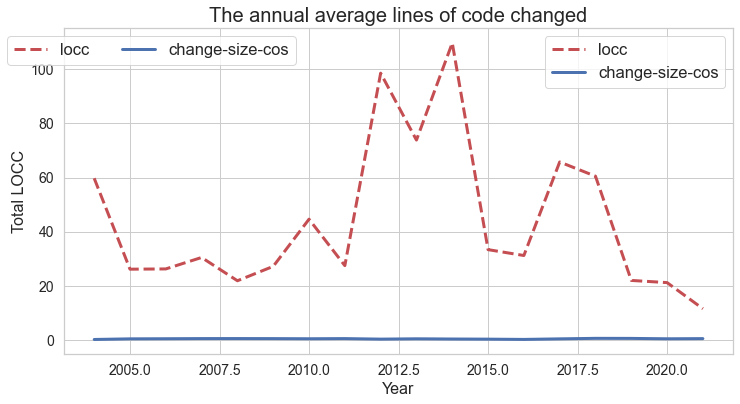

In [7]:
vis.plot_total_locc_avg()

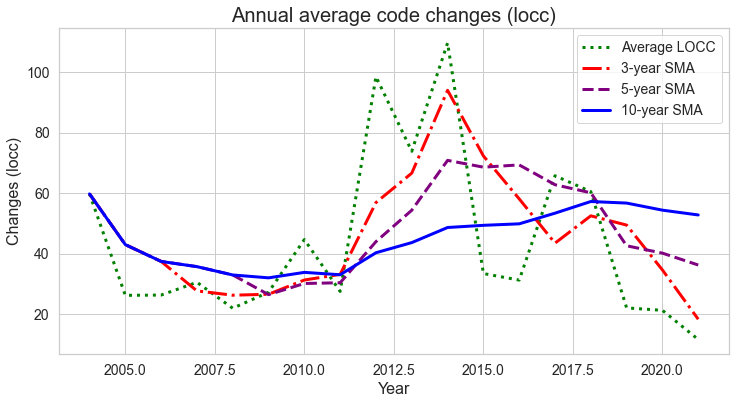

In [8]:
vis.plot_total_locc_moving_avgs()

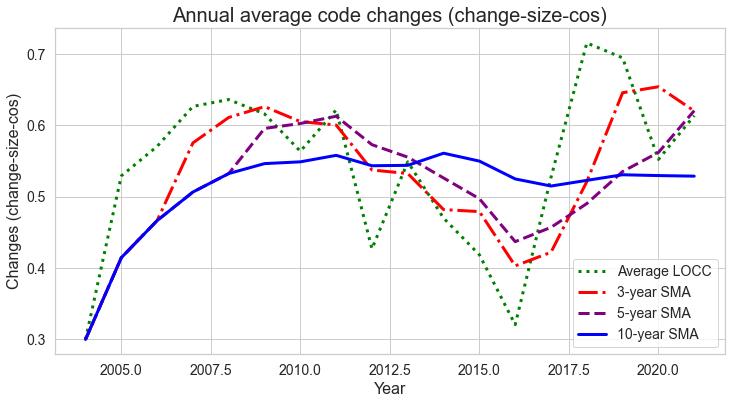

In [9]:
vis.plot_total_locc_moving_avgs(column='change-size-cos')

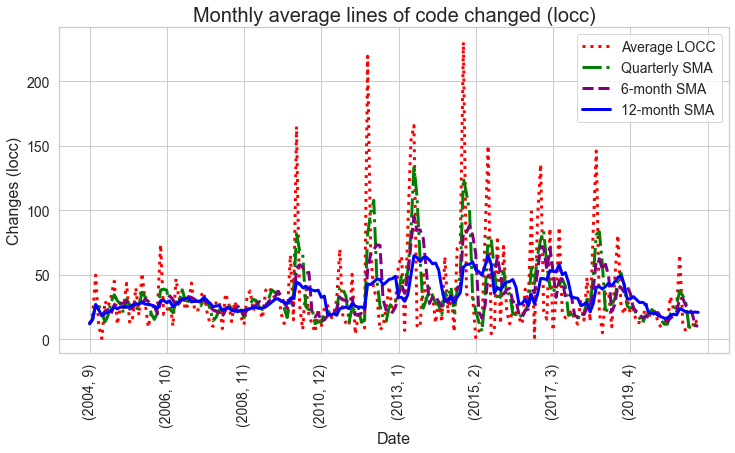

In [10]:
vis.plot_total_locc_moving_avgs_M()

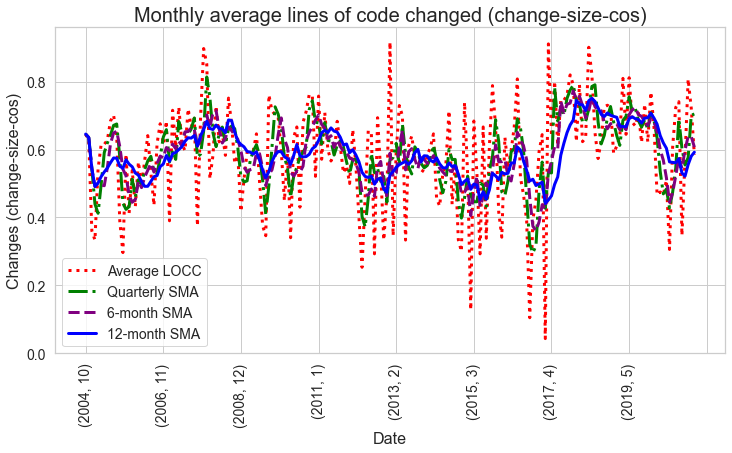

In [11]:
vis.plot_total_locc_moving_avgs_M(column='change-size-cos')

### Custom visualizations with derived data
This reflects changed lines of code as reported in git commit diffs.

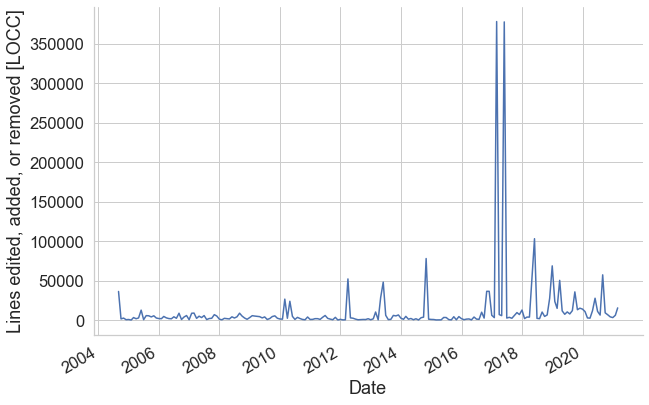

In [12]:
df = vis.plot_project_locc_line()

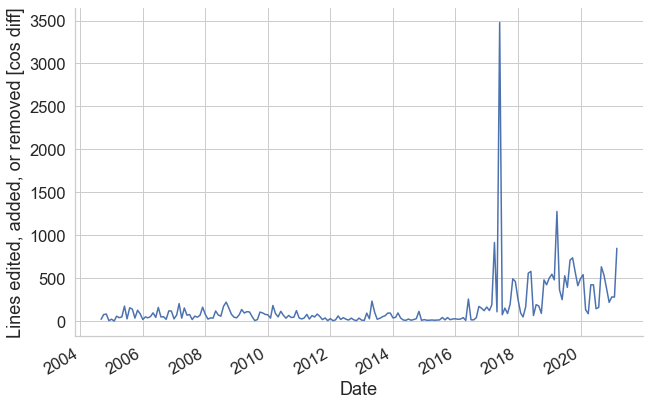

In [13]:
df2 = vis.plot_project_locc_line(locc=False)

,year,month,day,doy,locc-basic,locc,locc-,locc+,change-size-cos
datetime,,,,,,,,,
2004-08-31 00:00:00+00:00,749496,2992,9041,88703,36303,36164,604,35421,21
2004-09-30 00:00:00+00:00,234468,1053,2346,30894,1993,1413,333,500,76
2004-10-31 00:00:00+00:00,254508,1270,2660,37458,2890,2428,276,1690,82
2004-11-30 00:00:00+00:00,16032,88,84,2524,413,399,1,384,5
2004-12-31 00:00:00+00:00,122244,732,643,21078,752,639,47,479,22


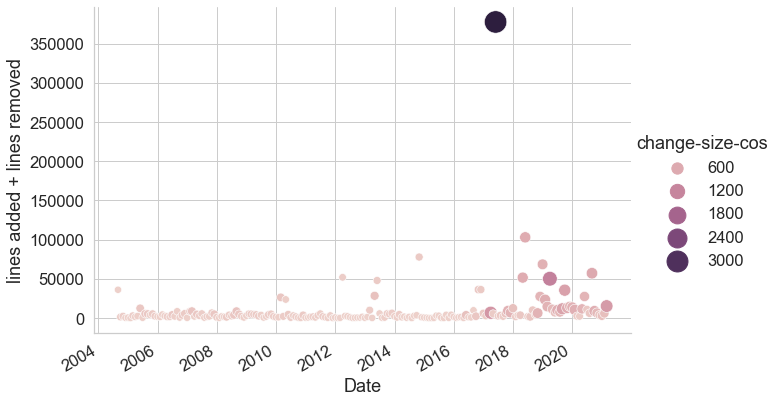

In [14]:
import seaborn as sns
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.relplot(data=df2, x="datetime", y="locc", size="change-size-cos", hue="change-size-cos", sizes=(50, 500),
                    height=6, aspect=1.5, kind="scatter")
    g.ax.set_xlabel('Date')
    g.ax.set_ylabel('lines added + lines removed')
    g.fig.autofmt_xdate()
    g.fig.show()
df.head()

### Using a distance metric to adjust the size of the changes

We use the python [textdistance](https://github.com/life4/textdistance) module. The following algorithms have been integrated with the visualizer.
```
'cos', 'hamming', 'damerau_levenshtein', 'jaccard', 'jaro', 'jaro_winkler', 'bag', 'editex'
```

,year,month,day,doy,locc-basic,locc,locc-,locc+,change-size-cos,change-size-jaccard
datetime,,,,,,,,,,
2004-08-31 00:00:00+00:00,749496,2992,9041,88703,36303,36164,604,35421,21,21
2004-09-30 00:00:00+00:00,234468,1053,2346,30894,1993,1413,333,500,76,76
2004-10-31 00:00:00+00:00,254508,1270,2660,37458,2890,2428,276,1690,82,82
2004-11-30 00:00:00+00:00,16032,88,84,2524,413,399,1,384,5,5
2004-12-31 00:00:00+00:00,122244,732,643,21078,752,639,47,479,22,22


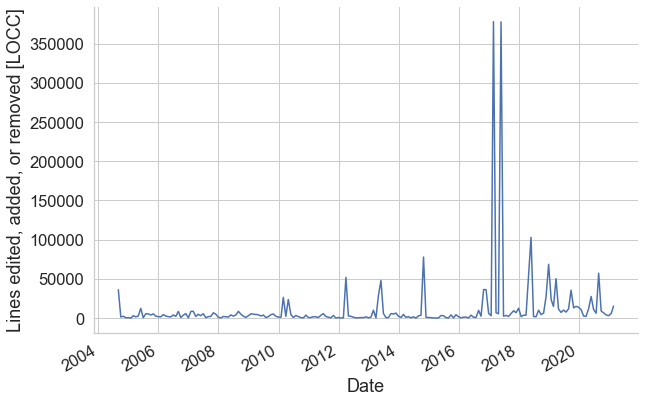

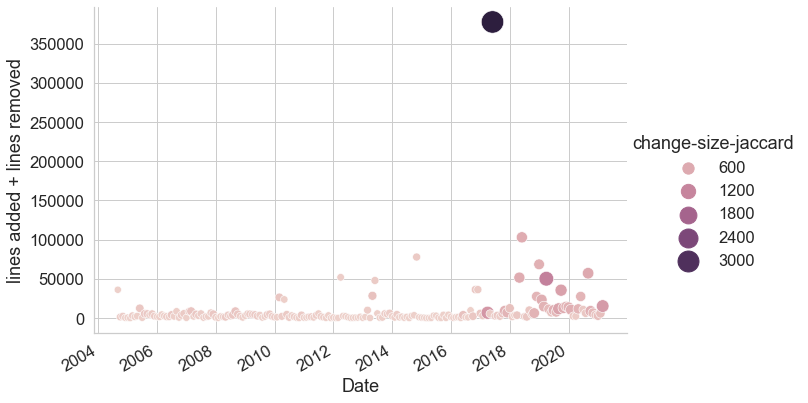

In [15]:
diff_alg = 'jaccard'
vis.set_diff_alg(diff_alg)
df = vis.plot_project_locc_line(diff_alg=diff_alg, log=False)
import seaborn as sns
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.relplot(data=df, x="datetime", y="locc", size="change-size-%s" % diff_alg, hue="change-size-%s" % diff_alg, sizes=(50, 500),
                    height=6, aspect=1.5, kind="scatter")
    g.ax.set_xlabel('Date')
    g.ax.set_ylabel('lines added + lines removed')
    g.fig.autofmt_xdate()
    g.fig.show()
df.head()

## Change size over time

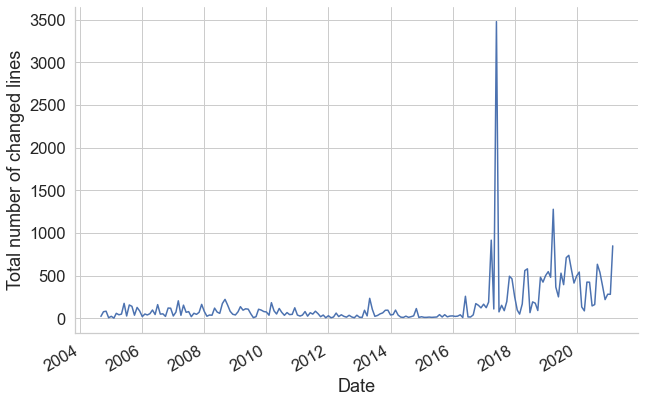

In [16]:
df = vis.plot_proj_change_size(time_range=None)

Similarly, we can 'zoom' into a specific year

(                              year  month    day     doy  locc-basic   locc  \
 datetime                                                                      
 2020-01-31 00:00:00+00:00  1640240    812   9490    9490       13437  10663   
 2020-02-29 00:00:00+00:00   571660    566   2556   11329        3128   2642   
 2020-03-31 00:00:00+00:00   365620    543   2843   13703        2831   2361   
 2020-04-30 00:00:00+00:00  1830120   3624  20285  102731       13888  11762   
 2020-05-31 00:00:00+00:00  1672560   4140  13636  113824       30955  27593   
 2020-06-30 00:00:00+00:00   951420   2826   4824   76416       11940  10990   
 2020-07-31 00:00:00+00:00   533280   1848   4543   52591        6723   6251   
 2020-08-31 00:00:00+00:00  1763460   6984  14677  200626       84658  57236   
 2020-09-30 00:00:00+00:00  1466520   6534  10605  187749       11530   9095   
 2020-10-31 00:00:00+00:00  2205840  10920  14120  313328        8203   6631   
 2020-11-30 00:00:00+00:00   765580   41

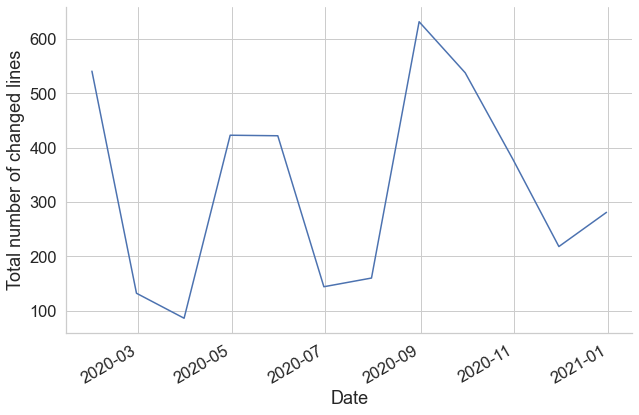

In [17]:
vis.plot_proj_change_size(time_range='year')

Or a specific year range

,year,month,day,doy,locc-basic,locc,locc-,locc+,change-size-cos,change-size-jaccard,date
datetime,,,,,,,,,,,
2004-09-30 00:00:00+00:00,983964,4045,11387,119597,38296,37577,-2.971740,4.555348,97,1.986772,2004-09-30
2004-12-31 00:00:00+00:00,392784,2090,3387,61060,4055,3466,-2.510545,3.407051,109,2.037426,2004-12-31
2005-03-31 00:00:00+00:00,346865,408,2565,9655,5167,4755,-3.053846,3.506640,98,1.991226,2005-03-31
2005-06-30 00:00:00+00:00,787965,1925,4794,50792,17011,15567,-3.593840,4.008515,248,2.394452,2005-06-30
2005-09-30 00:00:00+00:00,1058640,4093,9161,117036,16541,14828,-3.200029,4.061829,329,2.517196,2005-09-30
...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 00:00:00+00:00,2577520,1921,14889,34522,19396,15666,-3.485863,3.948168,759,2.880242,2020-03-31
2020-06-30 00:00:00+00:00,4454100,10590,38745,292971,56783,50345,-4.304340,4.375737,989,2.995196,2020-06-30
2020-09-30 00:00:00+00:00,3763260,15366,29825,440966,102911,72582,-4.056752,4.489354,1330,3.123852,2020-09-30


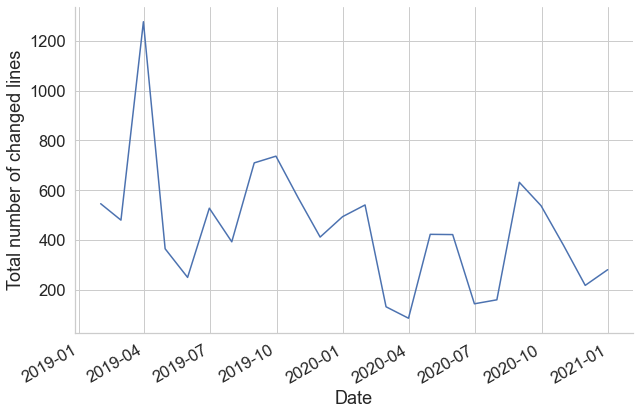

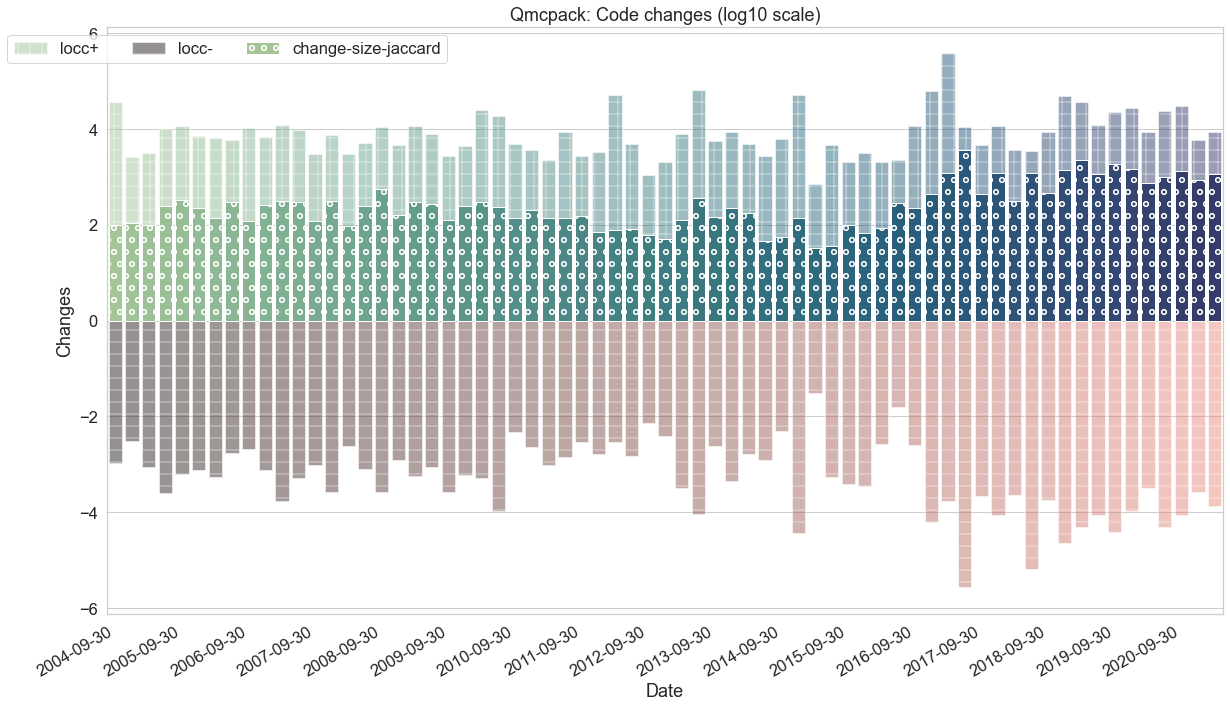

In [18]:
vis.select_year_range(2019,2020)
vis.plot_proj_change_size(time_range='year-year')
vis.plot_overall_project_locc(time_range='year-year',log=True)

we can zoom into a month

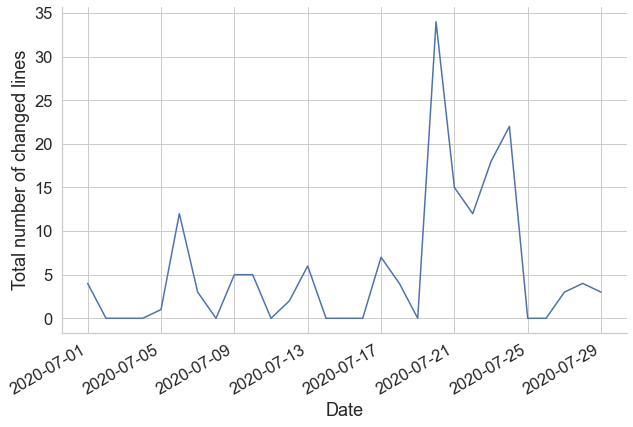

In [19]:
_ = vis.plot_proj_change_size(time_range='month')

Or a month range

(                              year  month    day     doy  locc-basic   locc  \
 datetime                                                                      
 2019-05-31 00:00:00+00:00   621852   1540   4324   41284        9930   7256   
 2019-06-30 00:00:00+00:00  1566744   4656  14820  131996       12093  10247   
 2019-07-31 00:00:00+00:00  1185153   4109   8083  114330        9340   7690   
 2019-08-31 00:00:00+00:00  2027076   8032  21287  234135       14600  11917   
 2019-09-30 00:00:00+00:00  2396553  10683  15950  304391       38469  35634   
 2019-10-31 00:00:00+00:00  1562706   7740   9289  220591       15353  13041   
 2019-11-30 00:00:00+00:00  1336578   7282   9878  211126       16242  14982   
 2019-12-31 00:00:00+00:00        0      0      0       0           0      0   
 2020-01-31 00:00:00+00:00        0      0      0       0           0      0   
 2020-02-29 00:00:00+00:00        0      0      0       0           0      0   
 2020-03-31 00:00:00+00:00        0     

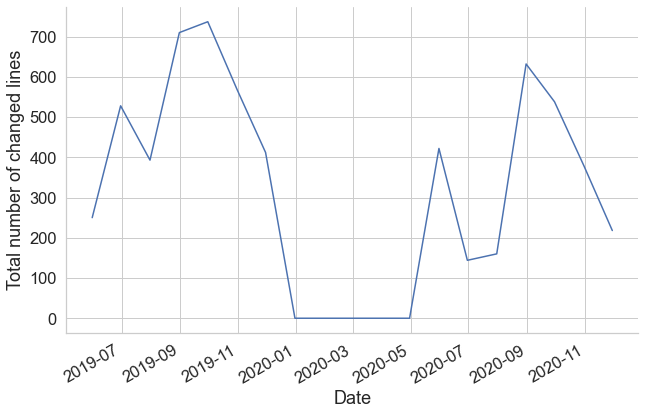

In [20]:
vis.select_month_range(5,11)
vis.plot_proj_change_size(time_range='month-month')

## More patterns
Here we look at a combination of the the high-churn and domain champion patterns. Basically we are focusing on the files that have the most changes and restricting the developers by those with the biggest contributions.

author,Ye Luo,Jeongnim Kim,jeongnim,Jaron Krogel,mmorale3,Mark Dewing,Fionn Malone,Jeremy McMinis,Paul Kent,Peter Doak
filepath,,,,,,,,,,
external_codes/..._algorithms.hpp,5187,0,5187,0,0,0,0,0,0,0
external_codes/...catch/catch.hpp,57,0,0,0,0,18545,0,0,0,0
external_codes/...full_lambda.hpp,3813,0,3813,0,0,0,0,0,0,0
external_codes/...istribution.hpp,6619,464,6155,0,0,0,0,0,0,0
src/AFQMC/Hamil...Hamiltonian.cpp,16,0,0,0,12025,1097,2513,0,43,0


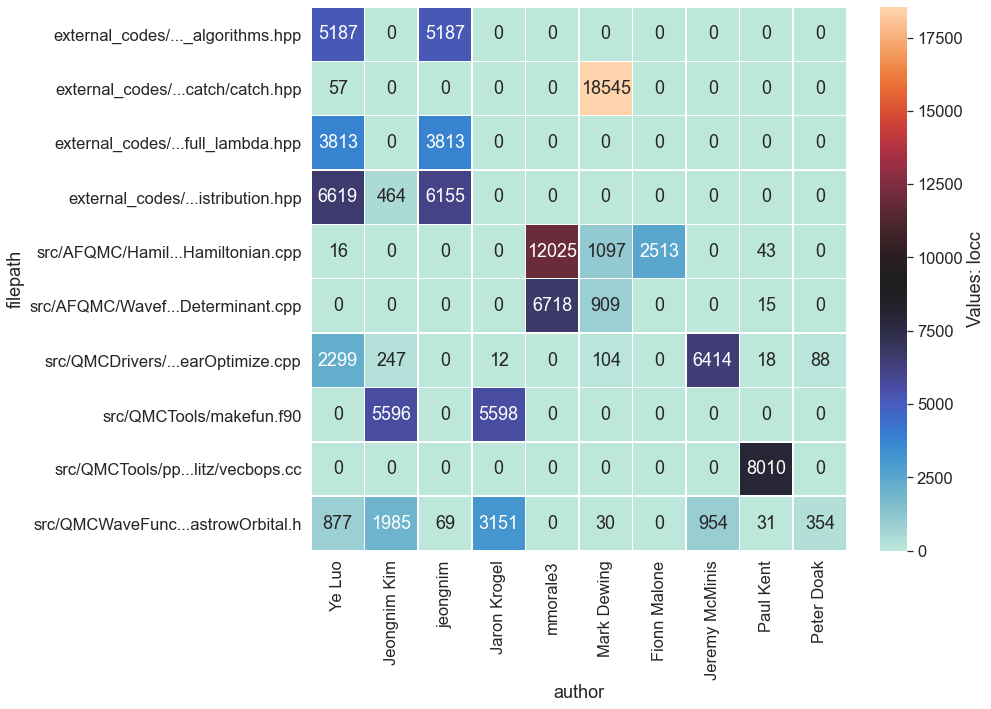

In [21]:
N = 10
vis.set_max_label_length(30)
top_N = vis.plot_top_N_heatmap(N, value_column='locc')
top_N.head()

author,Ye Luo,Jeongnim Kim,Peter Doak,Jaron Krogel,Jeremy McMinis,Paul Kent,Mark Dewing,Ken Esler,rcclay,Mark Berrill
filepath,,,,,,,,,,
src/Particle/ParticleSet.cpp,81,40,7,2,8,0,5,0,3,0
src/QMCDrivers/...CUpdatePbyP.cpp,60,42,5,4,23,5,5,1,0,4
src/QMCDrivers/...earOptimize.cpp,67,14,10,4,143,6,16,1,0,3
src/QMCDrivers/QMCDriver.cpp,19,78,7,2,16,1,2,2,0,0
src/QMCWaveFunc...Determinant.cpp,97,21,11,0,5,2,2,1,7,0


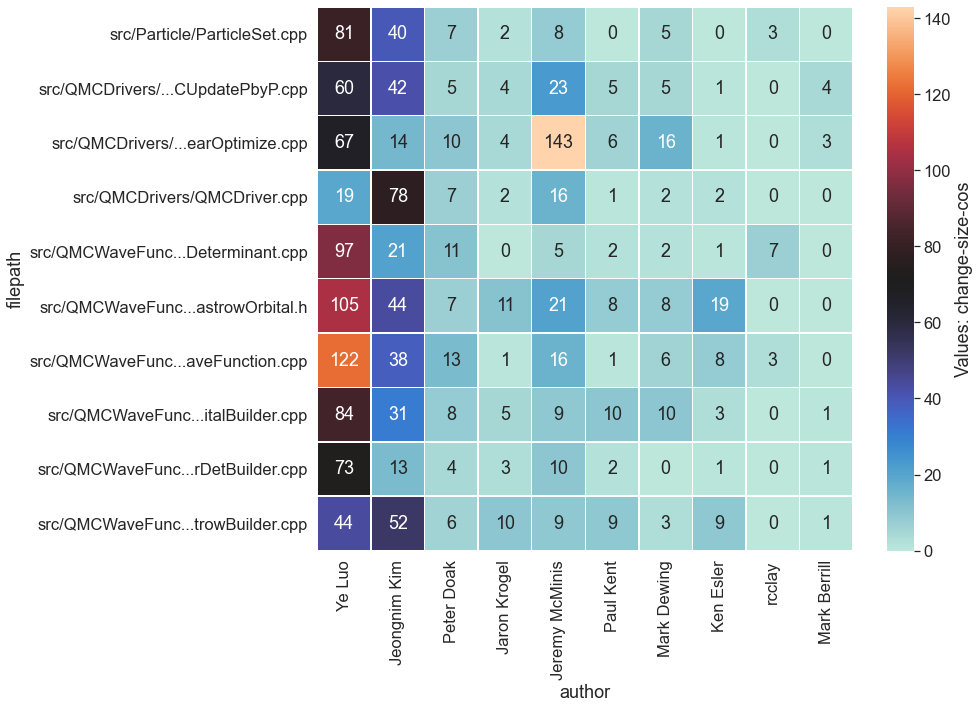

In [22]:
import seaborn as sns
top_N = vis.plot_top_N_heatmap(N, value_column='change-size-cos')
top_N.head()

In [23]:
from patterns.patterns import Patterns
df = vis.commit_data

In [24]:
vis.reset()
vis.annotate_metrics(diff_alg='cos')
file_dev_locc = vis.make_file_developer_df(value_column='locc')
file_dev_diff = vis.make_file_developer_df(value_column='change-size-cos')

In [25]:
diff_df = file_dev_locc.sub(file_dev_diff, axis=0)
print(diff_df.shape)
diff_df.head()

(6681, 88)


author,Alfredo A. Correa,Alfredo Correa,Andrea Zen,Andreas Tillack,Anouar Benali,Bradley Protano,Bryan K. Clark,Chandler Bennett,ChangMo Yang,Cody A. Melton,...,chrislzhao,jeongnim,jnkim,kryczko,mmorale3,naromero77,qmc,rcclay,root,spinedaflores
filepath,,,,,,,,,,,,,,,,,,,,,
.gitlab-ci.yml,0.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CMake/CheckAtomic.cmake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CMake/CheckProcessorID.cmake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CMake/CheckSincos.cmake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CMake/ClangCompilers.cmake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


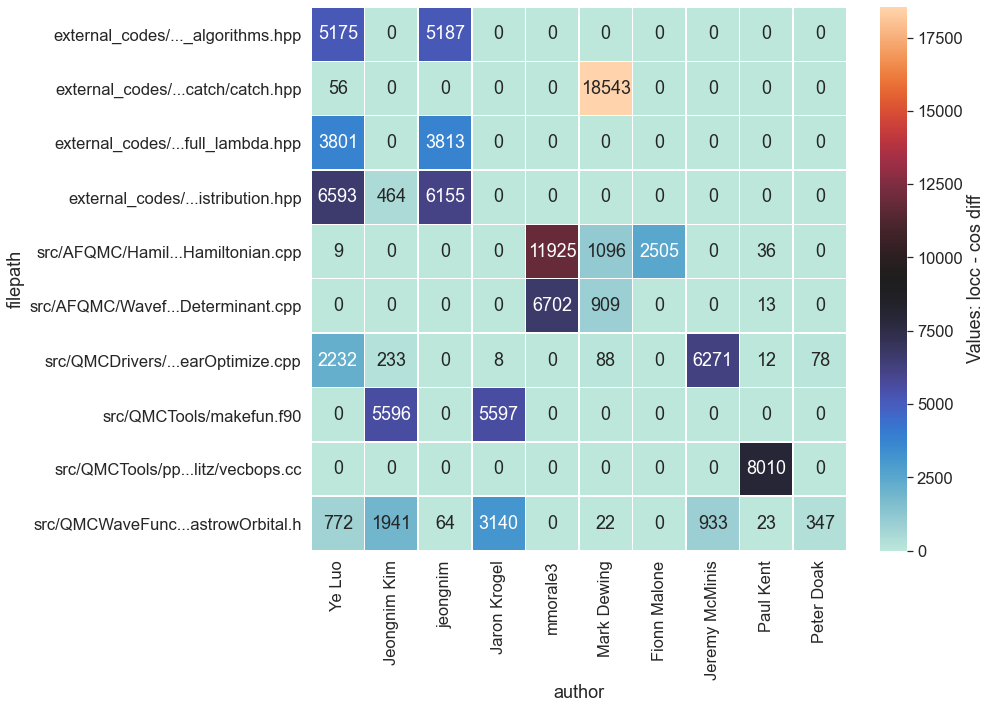

In [26]:
df = vis.commit_data
df['locc - cos diff'] = df['locc']-df['change-size-cos']
d = vis.plot_top_N_heatmap(top_N = 10, value_column='locc - cos diff', my_df=df)

## Did anything unusual happen in 2020?


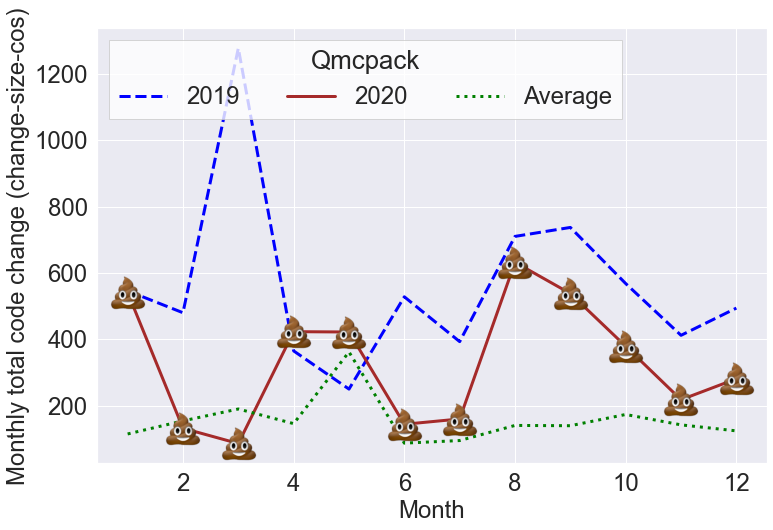

In [27]:
vis.how_was_2020('change-size-cos')

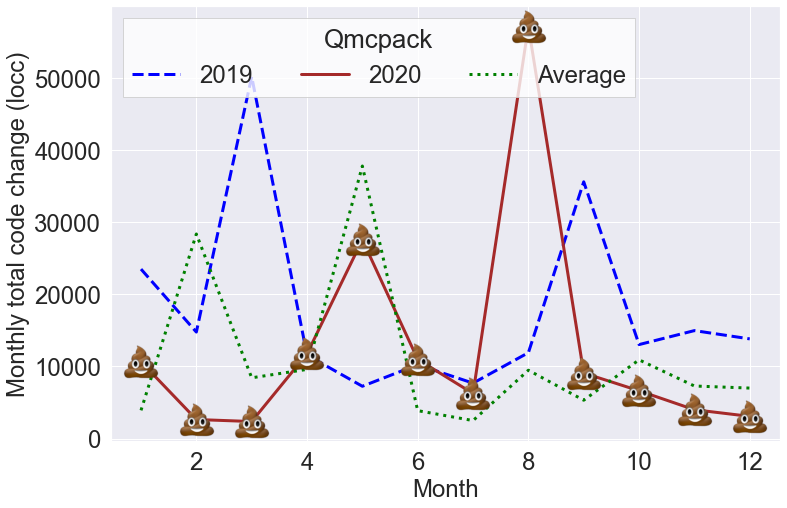

In [28]:
vis.how_was_2020('locc')